
    Column names in dataset:
    
    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn

In [9]:
# Importing data files:
train=pd.read_csv('data/train.csv',encoding='ISO-8859-1')
test= pd.read_csv('data/test.csv',encoding='ISO-8859-1')
train.set_index(train['ticket_id'],inplace=True)
test.set_index(test['ticket_id'],inplace=True)

del (train['ticket_id'])
del (test['ticket_id'])

address=pd.read_csv('data/addresses.csv',encoding='ISO-8859-1')
latlons=pd.read_csv('data/latlons.csv',encoding='ISO-8859-1')

FileNotFoundError: [Errno 2] File b'data/test.csv' does not exist: b'data/test.csv'

In [ ]:
# preliminary data exploration
# After exploring features, the following features were eliminated due to potential data leakage problems:
# 'compliance_detail','payment_status', 'payment_date','payment_amount', 'balance_due'  

eliminated_features=['compliance_detail','payment_status', 'payment_date','payment_amount', 'balance_due','collection_status']

# Train Set

df_train=train.drop(train[eliminated_features], axis=1)


In [ ]:
# Merging 'address.csv' and 'latlons.csv'
# Adding logitutde and latitude of propeties can help us to understand if the location is an important factor. 
address_latlons=pd.merge(address,latlons,how='left', left_on='address', right_on='address')

In [ ]:
# Definning bins for lon and lat
num_lats_bins=21 
num_lons_bins=21 

lat_bins=np.linspace(min(address_latlons['lat']),max(address_latlons['lat']),num_lats_bins)
lon_bins=np.linspace(min(address_latlons['lon']),max(address_latlons['lon']),num_lons_bins)


# Some zones have few records in. They usually are at the margins of the cities. We merged these zones together.

lat_bins=np.linspace(42.1882721,42.5906182,21).tolist()
lon_bins=np.linspace(min(address_latlons['lon']),max(address_latlons['lon']),15)
lat_bins.append(45.809387)
lat_bins.append(41.785926)
lat_bins=sorted(lat_bins)


In [ ]:
lon_bins=np.linspace(-83.64382659,-82.83700446,19).tolist()
#lat_bins=[41.785926,lat_bins,45.809387]
lon_bins.append(-88.0813483)
lon_bins.append(-82.4335934)
lon_bins=sorted(lon_bins)


In [ ]:
# Zoning lat:
address_latlons['zone_lat']=pd.cut(address_latlons['lat'], lat_bins, labels=False, retbins=False, right=False)

# Zoning lon:
address_latlons['zone_lon']=pd.cut(address_latlons['lon'], lon_bins, labels=False, retbins=False, right=False)


In [5]:
# Creating a mesh of regions based on the longitude and latitude
address_latlons['zone_lat']=address_latlons['zone_lat'].astype(str)
address_latlons['zone_lon']=address_latlons['zone_lon'].astype(str)
address_latlons['zone']=address_latlons['zone_lat'].str.cat(address_latlons['zone_lon'],sep='-')

NameError: name 'address_latlons' is not defined

In [6]:
# merging address_latlons with df_train and df_test sets:
train_address_latlons=pd.merge(df_train,address_latlons,how='left', left_on='ticket_id', right_on='ticket_id')
test_address_latlons=pd.merge(df_test,address_latlons,how='left', left_on='ticket_id', right_on='ticket_id')
train_address_latlons
df_train1= train_address_latlons.set_index('ticket_id')
df_test1=test_address_latlons.set_index('ticket_id')

NameError: name 'df_train' is not defined

In [7]:
# Exploring the features:
df_train1.describe()

NameError: name 'df_train1' is not defined

In [328]:
# Missing Values
# We get the unique values of each feature to see how informative they are:
#Exploring contetnt of features:
for col in list(df_train1.columns):
    print('\n Feature: {} \n\n{}' .format(col,df_train1[col].value_counts()))


 Feature: agency_name 

Buildings, Safety Engineering & Env Department    157784
Department of Public Works                         74717
Health Department                                   8903
Detroit Police Department                           8900
Neighborhood City Halls                                2
Name: agency_name, dtype: int64

 Feature: inspector_name 

Morris, John        17926
Steele, Jonathan    13237
Samaan, Neil J      12733
O'Neal, Claude      11591
Devaney, John       10769
                    ...  
Fisher, Rodney          1
Johnson, James          1
Walton, William         1
YOUNG, GERALDINE        1
Doneghy, John           1
Name: inspector_name, Length: 173, dtype: int64

 Feature: violator_name 

INVESTMENT, ACORN              809
INVESTMENT CO., ACORN          425
BANK, WELLS FARGO              328
MILLER, JOHN                   205
SHIFMAN, ALLEN                 192
                              ... 
AL-JEBORI, HUSSAIN & MOHSIN      1
WINBORN, JEANINE        


 Feature: lat 

42.377249    595
42.341730    495
42.341729    481
42.410855    442
42.352331    377
            ... 
42.354091      1
42.376523      1
42.436261      1
42.355551      1
42.435752      1
Name: lat, Length: 78694, dtype: int64

 Feature: lon 

-83.238943    595
-83.262271    495
-83.262245    481
-83.046409    442
-83.252023    377
             ... 
-83.184260      1
-83.017356      1
-83.095659      1
-83.177403      1
-83.083605      1
Name: lon, Length: 87249, dtype: int64

 Feature: zone_lat 

12.0    46915
11.0    45857
10.0    45010
13.0    38628
9.0     37478
8.0     22467
7.0      7422
6.0      3549
5.0      1471
4.0      1132
3.0       163
14.0      129
21.0       32
0.0        10
17.0        8
16.0        8
19.0        7
18.0        6
15.0        6
nan         4
20.0        3
2.0         1
Name: zone_lat, dtype: int64

 Feature: zone_lon 

12.0    51152
11.0    38532
10.0    36849
13.0    32062
15.0    28483
16.0    23428
14.0    20677
9.0     17365
17.0     1

In [329]:
# There features with a large number of unique values. These feature can not help us to predict the ticket compliance.
# Also we do not need 'address', lat', 'lon', 'zone_lon', 'zone_lat', ''
# The following features will be eliminated: 'violator_name','violation_street_number','violation_street_name','mailing_address_str_number',
# 'mailing_address_str_name','zip_code', 'country', 'address', 'lat', 'lon', 'zone_lat', 'zone_lon'
eliminated_features=['violator_name','violation_street_number','violation_street_name','mailing_address_str_number',
 'mailing_address_str_name','zip_code', 'country', 'address', 'lat', 'lon', 'zone_lat', 'zone_lon']

# Train data Set
df_train1=df_train1.drop(df_train1[eliminated_features], axis=1)

# Test data set
df_test1=df_test1.drop(df_test1[eliminated_features], axis=1)


In [330]:
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250306 entries, 22056 to 325561
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   agency_name            250306 non-null  object 
 1   inspector_name         250306 non-null  object 
 2   violation_zip_code     0 non-null       float64
 3   city                   250306 non-null  object 
 4   state                  250213 non-null  object 
 5   non_us_str_code        3 non-null       object 
 6   ticket_issued_date     250306 non-null  object 
 7   hearing_date           237815 non-null  object 
 8   violation_code         250306 non-null  object 
 9   violation_description  250306 non-null  object 
 10  disposition            250306 non-null  object 
 11  fine_amount            250305 non-null  float64
 12  admin_fee              250306 non-null  float64
 13  state_fee              250306 non-null  float64
 14  late_fee               250306 no

In [331]:
# Missin Values
# Eliminating Features with large number of missing value:
# As can be seen from above, the following columns have a lot of missing value. 
# violation_zip_code, non_us_str_code, grafitti_status

eliminated_features=['violation_zip_code', 'non_us_str_code', 'grafitti_status']

# Train data Set
df_train1=df_train1.drop(df_train[eliminated_features], axis=1)

# Test data set
df_test1=df_test1.drop(df_test[eliminated_features], axis=1)

# state and hearing_date have some missing value, They are replaced with mode of each featurs:
state_mode=df_train1['state'].mode()
hearing_date_mode=df_train1['hearing_date'].mode()


df_train1['state'].fillna(df_train1['state'].mode()[0],inplace=True)
df_train1['hearing_date'].fillna(df_train1['hearing_date'].mode()[0],inplace=True)

df_train1

,agency_name,inspector_name,city,state,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,zone
ticket_id,,,,,,,,,,,,,,,,,,
22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",CHICAGO,IL,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,11.0-12.0
27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Detroit,MI,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,1.0,7.0-12.0
22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",DETROIT,MI,2004-04-26 13:40:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10.0-13.0
22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",DETROIT,MI,2004-04-26 13:30:00,2005-12-22 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10.0-13.0
22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",DETROIT,MI,2004-04-26 13:00:00,2005-03-29 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0-10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325555,"Buildings, Safety Engineering & Env Department","Bush, Wesley",DETROIT,MI,2010-12-02 11:00:00,2015-01-06 09:00:00,9-1-43(a) - (Structu,Fail to comply with an Emergency or imminent d...,Not responsible by City Dismissal,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,12.0-11.0
325557,"Buildings, Safety Engineering & Env Department","Bush, Wesley",DETROIT,MI,2010-12-02 11:00:00,2015-01-06 09:00:00,9-1-43(a) - (Structu,Fail to comply with an Emergency or imminent d...,Not responsible by City Dismissal,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10.0-11.0
325562,"Buildings, Safety Engineering & Env Department","Bush, Wesley",DETROIT,MI,2010-12-02 11:00:00,2015-01-06 09:00:00,9-1-43(a) - (Structu,Fail to comply with an Emergency or imminent d...,Not responsible by City Dismissal,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,10.0-11.0


In [332]:
# Eliminating blight ticket with NaN value:
df_train1=df_train1[pd.notna(df_train1['compliance'])]
print('\n \nAfter eliminating some features and NaN in compliance feature:  \n ')
df_train1


 
After eliminating some features and NaN in compliance feature:  
 


,agency_name,inspector_name,city,state,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance,zone
ticket_id,,,,,,,,,,,,,,,,,,
22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",CHICAGO,IL,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,11.0-12.0
27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Detroit,MI,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Failed To Secure Permit For Lawful Use Of Buil...,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,1.0,7.0-12.0
22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",LOG BEACH,CA,2004-05-01 11:50:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,0.0-10.0
18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Clinton,MI,2004-06-14 14:15:00,2005-02-22 15:00:00,61-63.0500,Failed To Secure Permit For Lawful Use Of Land,Responsible by Default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0,13.0-14.0
18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Detroit,MI,2004-06-16 12:30:00,2005-02-22 15:00:00,61-63.0100,Noncompliance/Grant Condition/BZA/BSE,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,10.0-14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285106,Department of Public Works,"Zizi, Josue",DETROIT,MI,2011-12-27 14:50:00,2012-02-03 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,0.0,13.0-11.0
284650,Department of Public Works,"Lusk, Gertrina",DETROIT,MI,2011-12-29 09:50:00,2012-01-09 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,0.0,11.0-11.0
285125,Department of Public Works,"Bell, Maydell",DETROIT,MI,2011-12-29 09:30:00,2012-01-25 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,500.0,20.0,10.0,50.0,0.0,0.0,580.0,0.0,9.0-12.0


In [333]:
# All values in clean_up_cost are 0. This feature should be eliminated:
# violation_description and violation_code are the same. Violation_description will be eliminated.
eliminated_features=['clean_up_cost', 'violation_description']

# Train data Set
df_train1=df_train1.drop(df_train1[eliminated_features], axis=1)

# Test data set
df_test1=df_test1.drop(df_test1[eliminated_features], axis=1)



#df_train3=df_train3.reset_index()
#df_test1=df_test1[columns_test]
df_train1

,agency_name,inspector_name,city,state,ticket_issued_date,hearing_date,violation_code,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,compliance,zone
ticket_id,,,,,,,,,,,,,,,,
22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",CHICAGO,IL,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Responsible by Default,250.0,20.0,10.0,25.0,0.0,305.0,0.0,11.0-12.0
27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Detroit,MI,2004-04-23 12:30:00,2005-05-06 13:30:00,61-63.0600,Responsible by Determination,750.0,20.0,10.0,75.0,0.0,855.0,1.0,7.0-12.0
22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",LOG BEACH,CA,2004-05-01 11:50:00,2005-03-21 10:30:00,9-1-36(a),Responsible by Default,250.0,20.0,10.0,25.0,0.0,305.0,0.0,0.0-10.0
18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Clinton,MI,2004-06-14 14:15:00,2005-02-22 15:00:00,61-63.0500,Responsible by Default,750.0,20.0,10.0,75.0,0.0,855.0,0.0,13.0-14.0
18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Detroit,MI,2004-06-16 12:30:00,2005-02-22 15:00:00,61-63.0100,Responsible by Default,100.0,20.0,10.0,10.0,0.0,140.0,0.0,10.0-14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285106,Department of Public Works,"Zizi, Josue",DETROIT,MI,2011-12-27 14:50:00,2012-02-03 09:00:00,22-2-88(b),Responsible by Default,200.0,20.0,10.0,20.0,0.0,250.0,0.0,13.0-11.0
284650,Department of Public Works,"Lusk, Gertrina",DETROIT,MI,2011-12-29 09:50:00,2012-01-09 09:00:00,22-2-88(b),Responsible by Default,1000.0,20.0,10.0,100.0,0.0,1130.0,0.0,11.0-11.0
285125,Department of Public Works,"Bell, Maydell",DETROIT,MI,2011-12-29 09:30:00,2012-01-25 09:00:00,22-2-88(b),Responsible by Default,500.0,20.0,10.0,50.0,0.0,580.0,0.0,9.0-12.0


In [334]:
# Creating new features:
# Train data set  
    #in_city: if the a violator lives in Detroit
df_train1['city']=df_train1['city'].str.upper()
df_train1['in_city']=0
df_train1.loc[df_train1['city'] == 'DETROIT', 'in_city'] = 1
#df.loc[df['column name'] condition, 'new column name'] = 'value if condition is met'

    # in_state: if the violator lives in MI
df_train1['in_state']=0
df_train1.loc[df_train1['state'] == 'MI', 'in_state'] = 1


# test data set:
    #in_city: if the a violator lives in Detroit
df_test1['city']=df_test1['city'].str.upper()
df_test1['in_city']=0
df_test1.loc[df_test1['city'] == 'DETROIT', 'in_city'] = 1
#df.loc[df['column name'] condition, 'new column name'] = 'value if condition is met'

    # in_state: if the violator lives in MI
df_test1['in_state']=0
df_test1.loc[df_test1['state'] == 'MI', 'in_state'] = 1

In [335]:
   # 'violation_code'
# there are 189 unique violation codes in the data. Hiwever, the structure of the violation coding lets us to aggregate these codes. We considred the first two splits of
# the coding to recategrize violations. It gives us 33 violation categories.
    # train data set
xxx=df_train1['violation_code'].str.split('-', expand=True).iloc[:,:2]
xxx.columns=['0','1']
df_train1['violation_code_new']=xxx['0'].str.cat(xxx['1'], sep='-')

    # test data set
#### Note for test data set, we need to use the categorises that we defined based on train data set. if a violation code exist only in test data set, it will be ignored (considerd as Nan), since it was not in the our training model. 
xxx=df_test1['violation_code'].str.split('-', expand=True).iloc[:,:2]
xxx.columns=['0','1']
df_test1['violation_code_new']=xxx['0'].str.cat(xxx['1'], sep='-')
#df_test1=df_test1.merge(df_test1[['violation_code','violation_code_new']], left_on='violation_code', right_on='violation_code',how='left')
df_test1

,agency_name,inspector_name,city,state,ticket_issued_date,hearing_date,violation_code,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,zone,in_city,in_state,violation_code_new
ticket_id,,,,,,,,,,,,,,,,,,
284932,Department of Public Works,"Granberry, Aisha B",DETROIT,MI,2012-01-04 14:00:00,2012-01-19 09:00:00,22-2-61,Responsible by Default,200.0,20.0,10.0,20.0,0.0,250.0,11.0-15.0,1,1,22-2
285362,Department of Public Works,"Lusk, Gertrina",DETROIT,MI,2012-01-05 09:50:00,2012-02-06 09:00:00,22-2-88(b),Responsible by Default,1000.0,20.0,10.0,100.0,0.0,1130.0,12.0-10.0,1,1,22-2
285361,Department of Public Works,"Lusk, Gertrina",DETROIT,MI,2012-01-05 09:50:00,2012-02-06 09:00:00,22-2-43,Responsible by Default,100.0,20.0,10.0,10.0,0.0,140.0,12.0-10.0,1,1,22-2
285338,Department of Public Works,"Talbert, Reginald",WOODHAVEN,MI,2012-01-05 10:25:00,2012-02-07 09:00:00,22-2-88(b),Responsible by Default,200.0,20.0,10.0,20.0,0.0,250.0,7.0-12.0,0,1,22-2
285346,Department of Public Works,"Talbert, Reginald",LIVONIA,MI,2012-01-05 10:20:00,2012-02-14 09:00:00,22-2-45,Responsible by Default,100.0,20.0,10.0,10.0,0.0,140.0,6.0-12.0,0,1,22-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376496,"Buildings, Safety Engineering & Env Department","Pierson, Kevin",SOUTHFIELD,MI,2016-12-29 09:30:00,2017-01-23 10:30:00,9-1-43(a) - (Structu,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,1130.0,10.0-12.0,0,1,9-1
376497,"Buildings, Safety Engineering & Env Department","Pierson, Kevin",SOUTHFIELD,MI,2016-12-29 09:50:00,2017-01-23 10:30:00,9-1-43(a) - (Structu,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,1130.0,10.0-12.0,0,1,9-1
376499,Detroit Police Department,"BOWLES, TIFFANI",DETROIT,MI,2016-12-29 14:30:00,2017-01-20 09:00:00,22-2-45,Responsible by Default,100.0,20.0,10.0,10.0,0.0,140.0,11.0-15.0,1,1,22-2


In [336]:
# counting the number of violations of each types in each zone:
# Using crosstab we can create a table that shows how many of each violation occured in each zone. 

table=pd.crosstab(df_train1['zone'],df_train1['violation_code_new'])
table=table.reset_index()
table

violation_code_new,zone,22-2,22-3,61-101.0100/32.0066,61-104.0100,61-111.0100/32.0066,61-114.0100,61-118.0100/32.0066,61-120.0100/32.0066,61-121.0100/32.0066,...,61-82.0100/32.0066,61-83.0100/32.0031,61-83.0100/32.0066,61-84.0100/32.0066,61-84.0100/45.0807,61-86.0100/32.0066,61-86.0100/32.0076B,61-86.0100/45.0807,61-90.0100,9-1
0,0.0-10.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0.0-11.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0-3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,10.0-10.0,1058,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,3148
4,10.0-11.0,1412,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,4175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,9.0-16.0,167,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,859
109,9.0-7.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
110,9.0-8.0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
111,9.0-9.0,398,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,853


In [337]:
# Finding the number of each violations in zone that a ticket was issued:
# train data set:
df_train1=df_train1.reset_index().merge(table, left_on='zone', right_on='zone',how='left')

# test data set:
df_test1=df_test1.reset_index().merge(table, left_on='zone', right_on='zone',how='left')


In [338]:
# Handeling Date format:
    # train data set:
# Changing 'hearing_date' , 'ticket_issued_date' and  to date format:
df_train1['ticket_issued_date'] = pd.to_datetime(df_train1['ticket_issued_date'])
df_train1['hearing_date'] = pd.to_datetime(df_train1['hearing_date'])

# The differenc between 'hearing_date' and 'ticket_issued_date':
df_train1['time_between_ticket_hearing']=(df_train1['hearing_date'] - df_train1['ticket_issued_date']).dt.components.iloc[:,0]

# finding the day 0f hearing date:
df_train1['weekday_hearing_date']=df_train1['hearing_date'].dt.dayofweek.astype(str)

# if the ticket as has discount
df_train1['has_discount']=1
df_train1.loc[df_train1['discount_amount'] == 0, 'has_discount'] = 0


    # test data set:
# Changing 'hearing_date' , 'ticket_issued_date' and  to date format:
df_test1['ticket_issued_date'] = pd.to_datetime(df_test1['ticket_issued_date'])
df_test1['hearing_date'] = pd.to_datetime(df_test1['hearing_date'])

# The differenc between 'hearing_date' and 'ticket_issued_date':
df_test1['time_between_ticket_hearing']=(df_test1['hearing_date'] - df_test1['ticket_issued_date']).dt.components.iloc[:,0]

# finding the day 0f hearing date:
df_test1['weekday_hearing_date']=df_test1['hearing_date'].dt.dayofweek.astype(str)

# if the ticket as has discount
df_test1['has_discount']=1
df_test1.loc[df_test1['discount_amount'] == 0, 'has_discount'] = 0





In [339]:
# After some feature engineering, some features that were used for creating new features should be eliminated:
'city', 'state','ticket_issued_date', 'hearing_date', 'violation_code', 'admin_fee', 'state_fee','discount_amount','collection_status'

eliminated_features=['city', 'state','ticket_issued_date', 'hearing_date', 'violation_code',
                     'admin_fee', 'state_fee','discount_amount']

# Train data Set
df_train1=df_train1.drop(df_train1[eliminated_features], axis=1)

# Test data set
df_test1=df_test1.drop(df_test1[eliminated_features], axis=1)



In [340]:
# Expolring target feature:
print ('percent of compliance ticket in target: {:.2f}' 
       .format(np.round(df_train1['compliance'].value_counts()[1]/len(df_train1),decimals=3)))
print ('percent of non-compliance ticket in target: {:.2f}' 
       .format(np.round(df_train1['compliance'].value_counts()[0]/len(df_train1),decimals=3)))
# the data set is unbalanced. 

percent of compliance ticket in target: 0.07
percent of non-compliance ticket in target: 0.93


In [2]:
df_train1.columns

NameError: name 'df_train1' is not defined

In [341]:
df_train1

,ticket_id,agency_name,inspector_name,disposition,fine_amount,late_fee,judgment_amount,compliance,zone,in_city,...,61-84.0100/32.0066,61-84.0100/45.0807,61-86.0100/32.0066,61-86.0100/32.0076B,61-86.0100/45.0807,61-90.0100,9-1,time_between_ticket_hearing,weekday_hearing_date,has_discount
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",Responsible by Default,250.0,25.0,305.0,0.0,11.0-12.0,0,...,0,0,0,0,0,2,4717,369,0,0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Responsible by Determination,750.0,75.0,855.0,1.0,7.0-12.0,1,...,0,0,0,0,0,0,2017,378,4,0
2,22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",Responsible by Default,250.0,25.0,305.0,0.0,0.0-10.0,0,...,0,0,0,0,0,0,2,323,0,0
3,18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Responsible by Default,750.0,75.0,855.0,0.0,13.0-14.0,0,...,0,0,0,0,0,0,2485,253,1,0
4,18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin",Responsible by Default,100.0,10.0,140.0,0.0,10.0-14.0,1,...,0,0,0,0,0,0,1174,251,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159875,285106,Department of Public Works,"Zizi, Josue",Responsible by Default,200.0,20.0,250.0,0.0,13.0-11.0,1,...,0,0,0,0,0,0,2069,37,4,0
159876,284650,Department of Public Works,"Lusk, Gertrina",Responsible by Default,1000.0,100.0,1130.0,0.0,11.0-11.0,1,...,0,0,0,1,0,0,4586,10,0,0
159877,285125,Department of Public Works,"Bell, Maydell",Responsible by Default,500.0,50.0,580.0,0.0,9.0-12.0,1,...,0,0,0,0,0,0,4755,26,2,0
159878,284881,Department of Public Works,"Johnson, Lois",Responsible by Determination,200.0,0.0,230.0,1.0,12.0-14.0,1,...,1,0,0,0,0,0,2068,40,1,0


In [342]:
# One-hot Encoding
# 'disposition' it may be needed to be added again.
    # train data set
#df_train1=df_train1.set_index('ticket_id')
df_dummies= pd.DataFrame(pd.get_dummies(df_train1[['agency_name', 'inspector_name',  'zone', 'violation_code_new','disposition']]),index=df_train1.index)

df_train1=pd.merge(df_train1,df_dummies, how='left', left_index=True, right_index=True) 

# Droping the features that one hot encodes were created based on:
eliminated_features=['agency_name', 'inspector_name',  'zone', 'violation_code_new','disposition']
df_train1=df_train1.drop(df_train1[eliminated_features], axis=1)


# Test data set
df_test1=df_test1.set_index('ticket_id')
df_dummies= pd.DataFrame(pd.get_dummies(df_test1[['agency_name', 'inspector_name',  'zone', 'violation_code_new']]),index=df_test1.index)

df_test1=pd.merge(df_test1,df_dummies, how='left', left_index=True, right_index=True) 

# Droping the features that one hot encodes were created based on:
df_test1=df_test1.drop(df_test1[eliminated_features], axis=1)


In [343]:
df_train1

,ticket_id,fine_amount,late_fee,judgment_amount,compliance,in_city,in_state,22-2,22-3,61-101.0100/32.0066,...,violation_code_new_61-84.0100/45.0807,violation_code_new_61-86.0100/32.0066,violation_code_new_61-86.0100/32.0076B,violation_code_new_61-86.0100/45.0807,violation_code_new_61-90.0100,violation_code_new_9-1,disposition_Responsible (Fine Waived) by Deter,disposition_Responsible by Admission,disposition_Responsible by Default,disposition_Responsible by Determination
0,22056,250.0,25.0,305.0,0.0,0,0,1031,0,0,...,0,0,0,0,0,1,0,0,1,0
1,27586,750.0,75.0,855.0,1.0,1,1,652,5,0,...,0,0,0,0,0,0,0,0,0,1
2,22046,250.0,25.0,305.0,0.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,18738,750.0,75.0,855.0,0.0,0,1,812,0,0,...,0,0,0,0,0,0,0,0,1,0
4,18735,100.0,10.0,140.0,0.0,1,1,227,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159875,285106,200.0,20.0,250.0,0.0,1,1,809,0,0,...,0,0,0,0,0,0,0,0,1,0
159876,284650,1000.0,100.0,1130.0,0.0,1,1,1691,0,0,...,0,0,0,0,0,0,0,0,1,0
159877,285125,500.0,50.0,580.0,0.0,1,1,978,0,0,...,0,0,0,0,0,0,0,0,1,0
159878,284881,200.0,0.0,230.0,1.0,1,1,543,13,0,...,0,0,0,0,0,0,0,0,0,1


In [393]:
# Data transformation
import time
s=time.time()
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeClassifier


X=df_train1.iloc[:, df_train1.columns != 'compliance']
y=df_train1['compliance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

### Logistic Regression

C:\Users\Sepehr\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy validation set: 
0.795
Accuracy test set: 
0.795
Best parameter setting: 
{'clf__C': 1000}
Confusion matrix: 
[[37078     0]
 [ 2892     0]]
ROC_AUC: 
0.80


C:\Users\Sepehr\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


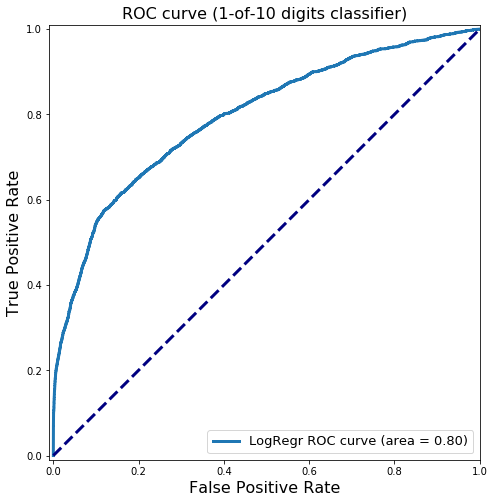

(39970,)
calculation_time112583.765609502792
               precision    recall  f1-score   support

no compliance       0.94      1.00      0.97     37078
   compliance       0.85      0.13      0.22      2892

     accuracy                           0.94     39970
    macro avg       0.89      0.56      0.60     39970
 weighted avg       0.93      0.94      0.91     39970



In [368]:
# Logistic Regression
# The combination of GridSerchCV and Pipeline
# The important parameter for Logisticregressio is C. Pipeline and Gridsearch were run to find the best paramers setting. 

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
#param_grid={clf_C:[0.0001,0.001,0.1,10,1000]}
param_grid = dict(clf__C=[0.1,10,1000])

pipe=Pipeline([('scaler',MinMaxScaler()), ('clf',LogisticRegression())])

# Since we have a unbalanced sample, auc works beter to find the best model
grid=GridSearchCV(pipe,param_grid, cv=5,n_jobs=-1,scoring='roc_auc')
grid.fit(X_train,y_train)
print('Accuracy validation set: \n{:.3}' .format(grid.best_score_))

print('Accuracy test set: \n{:.3}' .format(grid.score(X_test,y_test)))
print('Best parameter setting: \n{}' .format(grid.best_params_))

predictions=grid.predict(X_test)
confusion=confusion_matrix(y_test,pridictions)
print('Confusion matrix: \n{}'.format(confusion))

scores=grid.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc=auc(fpr, tpr)

print('ROC_AUC: \n{:.2f}' .format(roc_auc))

plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()
print(scores.shape)
e=time.time()

calculation_time1=e-s
print('calculation_time: \n{}'.format(calculation_time1))

from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['no compliance', 'compliance']))

### Ridge Classifier

Accuracy validation set: 
0.794
Accuracy test set: 
0.795
Best parameter setting: 
{'clf__alpha': 0.1}
Confusion matrix: 
[[37078     0]
 [ 2892     0]]
ROC_AUC: 
0.80


C:\Users\Sepehr\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


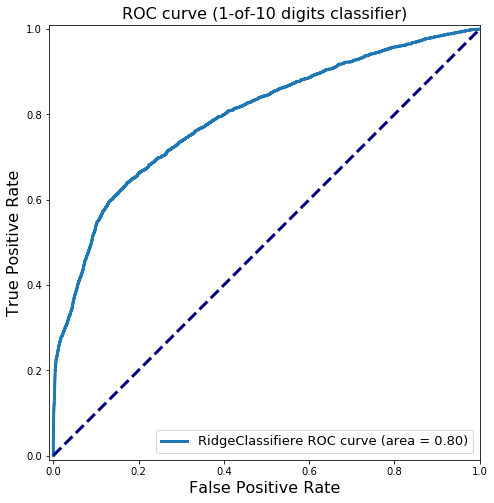

(39970,)
calculation_time: 
15769.801544189453
               precision    recall  f1-score   support

no compliance       0.93      1.00      0.97     37078
   compliance       0.88      0.11      0.19      2892

     accuracy                           0.93     39970
    macro avg       0.91      0.55      0.58     39970
 weighted avg       0.93      0.93      0.91     39970



In [374]:

from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
#param_grid={clf_C:[0.0001,0.001,0.1,10,1000]}
param_grid = dict(clf__alpha=[0.1,10])

pipe=Pipeline([('scaler',MinMaxScaler()), ('clf',RidgeClassifier())])


# Since we have a unbalanced sample, auc works beter to find the best model
grid=GridSearchCV(pipe,param_grid, cv=5,n_jobs=-1,scoring='roc_auc')
grid.fit(X_train,y_train)
print('Accuracy validation set: \n{:.3}' .format(grid.best_score_))

print('Accuracy test set: \n{:.3}' .format(grid.score(X_test,y_test)))
print('Best parameter setting: \n{}' .format(grid.best_params_))

predictions=grid.predict(X_test)
confusion=confusion_matrix(y_test,pridictions)
print('Confusion matrix: \n{}'.format(confusion))

scores=grid.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc=auc(fpr, tpr)

print('ROC_AUC: \n{:.2f}' .format(roc_auc))

plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='RidgeClassifiere ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()
print(scores.shape)
e=time.time()

calculation_time1=e-s
print('calculation_time: \n{}'.format(calculation_time1))

from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, target_names=['no compliance', 'compliance']))

In [ ]:
# Note that parameters from grid.cv_results can be used to draw Validation curve:
# The mean_fit_time, std_fit_time, mean_score_time and std_score_time.
# In the Next cell I use validation_curve to plot validation curve

#### Checking for Overfitting or Underfitting:

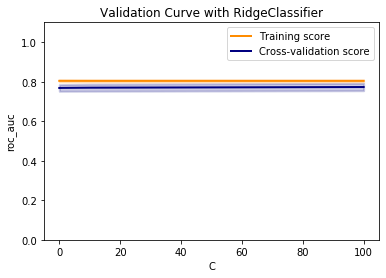

In [67]:
# Plotting Validation Curves:
from sklearn.model_selection import validation_curve
from sklearn.linear_model import RidgeClassifier
param_range=[0.0001,0.001,0.01, 0.1, 1, 10, 100]
#ridge=Ridge()
train_scores, test_scores = validation_curve(RidgeClassifier(), X, y, param_name="alpha",
param_range=param_range,cv=5, scoring='roc_auc')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve with RidgeClassifier')
plt.xlabel('alpha')
plt.ylabel('roc_auc')
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()




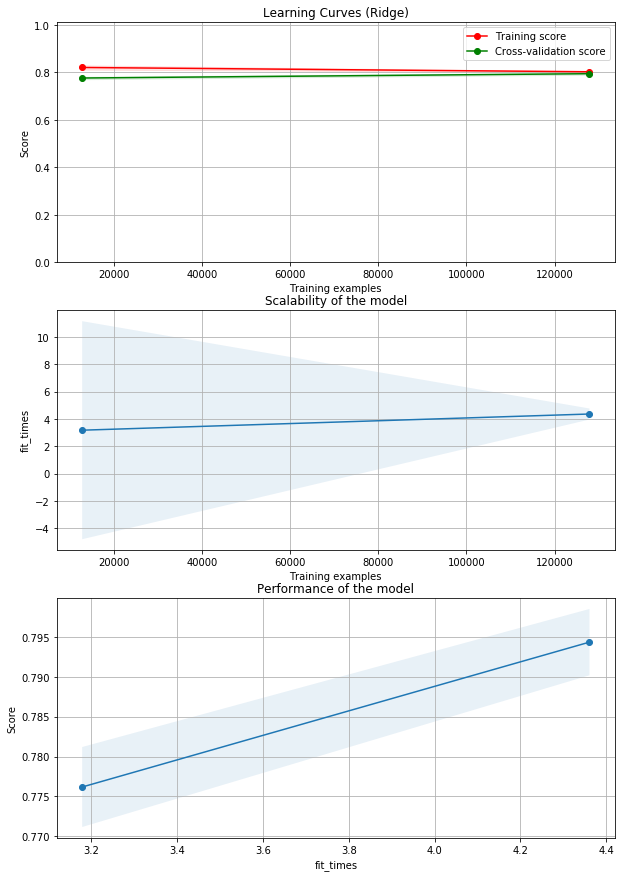

In [378]:
# Plotting Learning Curves:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 2)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv,
                       train_sizes=train_sizes,
                       return_times=True, scoring='roc_auc')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3,1, figsize=(10, 15))



title = 'Learning Curves (Ridge)'
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RidgeClassifier()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.0, 1.01),cv=cv)






plt.show()

### Random Forest Classfier

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import time
%matplotlib notebook
import seaborn as sns
import matplotlib.pyplot as plt


def train_roc_plot(X,y,clf):
    s=time.time()
    
    # Creating train and data set:
    X_train, X_test,y_train,y_test=train_test_split(X,y,random_state=0)
    
    # Creating pipeline for MinMaxScaler and classifier:
    pipe=Pipeline([('scaler',MinMaxScaler()), ('clf',clf)])
        
    #param_grid={clf_C:[0.0001,0.001,0.1,10,1000]}
    param_grid = dict(clf__n_estimators=[50,100,150,200,300],clf__max_features=['auto','log2'])
    
    # Since we have a unbalanced sample, auc works beter to find the best model
    grid=GridSearchCV(pipe,param_grid, cv=5,n_jobs=-1,scoring='roc_auc')
    grid.fit(X_train,y_train)
    predictions=grid.predict(X_test)
    
    
    print('Accuracy test set: \n{:.3}' .format(grid.score(X_test,y_test)))
    print('Best parameter setting: \n{}' .format(grid.best_params_))
    
    
    # Confusion Matrix:
    confusion=confusion_matrix(y_test,pridictions)
    print('\n\n')
    print('Confusion matrix: \n{}'.format(confusion))
    scores=grid.predict_proba(X_test)

    # ROC plotting
    fpr, tpr, _ = roc_curve(y_test, scores[:,1])

    roc_auc=auc(fpr, tpr)

    print('ROC_AUC: \n{:.2f}' .format(roc_auc))
    print('\n\n')
    plt.figure(figsize=(8,8))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr, tpr, lw=3, label='Random Forest ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    plt.axes().set_aspect('equal')
    plt.show()
    
    e=time.time()
        
    print('Time of processing(Minutes) : \n{}'.format((e-s)/60))
    
    
    from sklearn.metrics import classification_report
    print(classification_report(y_test, predictions, target_names=['no compliance', 'compliance']))
    results=pd.DataFrame(grid.cv_results_)
    
    #columns=['param_clf__n_estimators','param_clf__max_features','mean_test_score']
    
    #scores=results[columns].pivot(index='param_clf__n_estimators',columns='param_clf__max_features', values='mean_test_score').to_numpy()

    
    #plt.figure()
    #sns.heatmap(scores.reshape(len(param_grid['param_clf__n_estimators']),len(param_grid['param_clf__max_features'])), xticklabels=['l2'], yticklabels=[0.0001, 0.001,0.01])
    #plt.yticks(rotation=0);

    print('Time of processing(Minutes) : \n{}'.format((e-s)/60))

In [2]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier()
train_roc_plot(X,y,clf)

NameError: name 'X' is not defined

#### Checking for Overfitting or Underfitting:

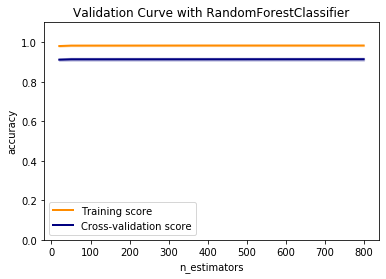

In [98]:
# Checking for Overfitting or Underfitting:
# Plotting Validation Curves:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier

param_range=[20,50,400,800]
#ridge=Ridge()
train_scores, test_scores = validation_curve(RandomForestClassifier(), X, y, param_name="n_estimators",
param_range=param_range,cv=5, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve with RandomForestClassifier')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()


C:\Users\Sepehr\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


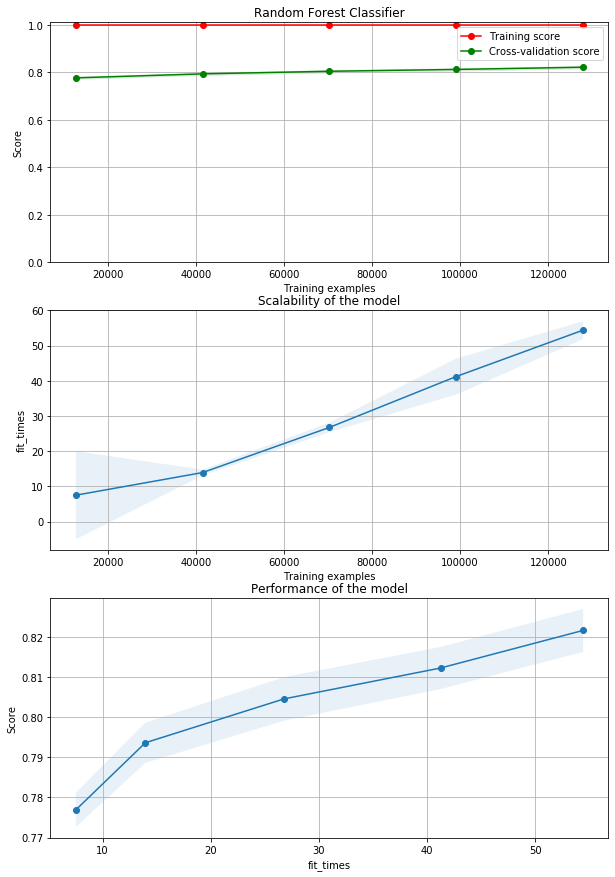

In [371]:
# Plotting Learning Curves:
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv,
                       train_sizes=train_sizes,
                       return_times=True, scoring='roc_auc')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(10, 15))



title = 'Random Forest Classifier'
RandomForestClassifier

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, axes=axes, ylim=(0.0, 1.01),cv=cv)


plt.show()